## SIMULATION NOTEBOOK :)

In [1]:
from SimulatorNN import Simulation, Vehicle, Client
from Utils import get_vehicle_assignment_nn
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch

from models import *
from evaluate_times import generate_event, generate_times, print_statistics

In [2]:
def show_statistics_time(total_info):
    f, ax = plt.subplots(2,2,figsize=(15,10), sharey=True)
    ax = ax.flatten()
    total_info.plot(kind='box', y='service_t_network', ax=ax[0])
    total_info.plot(kind='box', y='service_t_solution', ax=ax[1])
    ax[0].set_title('Service Time Net assignment')
    ax[1].set_title('Service Time Solution')

    total_info.plot(kind='box', y='travel_t_network', ax=ax[2])
    total_info.plot(kind='box', y='travel_t_solution', ax=ax[3])
    ax[2].set_title('Travel time Net assignment')
    ax[3].set_title('Travel time Solution')
    plt.show()
    

def results_comparison(total_info, cust1=0, cust2=10):
    # comparison of results
    simu = total_info[cust1:cust2]

    fig, ax = plt.subplots(figsize=(20,5))
    simu.plot(kind='scatter', x='arrival', y='ID', ax=ax, c='green')
    simu.plot(kind='scatter', x='pickup_t_network', y='ID', ax=ax, c='blue')
    simu.plot(kind='scatter', x='pickup_t_solution', y='ID', ax=ax, c='blue', marker='*', s=100)
    simu.plot(kind='scatter', x='dropoff_t_network', y='ID', ax=ax, c='black')
    simu.plot(kind='scatter', x='dropoff_t_solution', y='ID', ax=ax, c='black', marker = '*', s=100)

    #df_clients.iloc[1:10].plot(kind='scatter', x='max_time', y='ID', ax=ax, c='red')
    plt.legend(['Arrival', 'Pickup', 'Pickup - Solution', 'Dropoff', 'Dropoff - Solution'], loc=1)
    plt.grid()
    plt.title('10 customers ride times')
    plt.show()

def compute_obj(total_info, Event):
    return sum(total_info.delta_t_network), sum(v.ride_time for v in Event.vehicles)

### Evaluate performance of different models in terms of time 

We define:
- delta_time = dropoff time - client request arrival 
- travel_t = dropoff time - pickup time
- service_t = pickup time - client request arrival

In [3]:
TABLE = 8
NN = True

In [4]:
Event_base = generate_event(TABLE, 0, False, 0, 0)
df_clients_event_base, sol_event_base =  generate_times(Event_base)

In [5]:
delta_t_solution = sum(df_clients_event_base.delta_t)
ride_t_solution = sum(v.ride_time for v in Event_base.vehicles)

# Model 00. No extra info, only image. Clipped weigths

In [6]:
model00 = torch.load('model_weights2/model_simple_30_clipped.pt')
model00.eval()
num_channels = 2
im_size = 30

Event00 = generate_event(TABLE, model00, NN, num_channels, im_size, single_output=True)
df_clients_event00, sol_event00 =  generate_times(Event00)
total_info00 = pd.merge(df_clients_event00, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

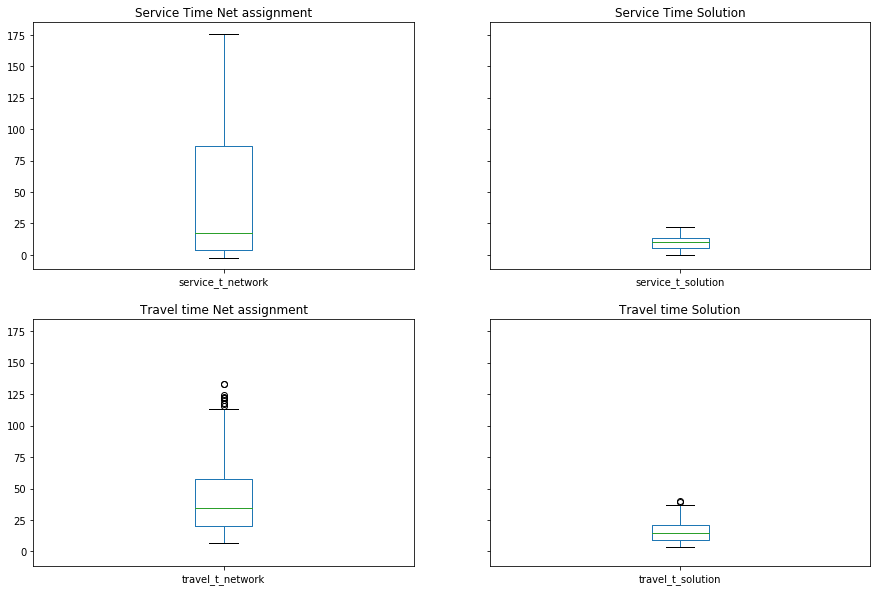

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294	


In [11]:
show_statistics_time(total_info00)

delt00, ride00 = compute_obj(total_info00, Event00)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt00, ride00, delt00+ride00))



## Model 1. Model with 31 channel input and no intermediate loss

In [6]:
model1 = torch.load('model_weights2/without_loss_weights.pt')
model1.eval()
num_channels = 31
im_size = 10

In [7]:
Event1 = generate_event(TABLE, model1, NN, num_channels, im_size)
df_clients_event1, sol_event1 =  generate_times(Event1)
total_info1 = pd.merge(df_clients_event1, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

Visualize results in terms of service time and travel time

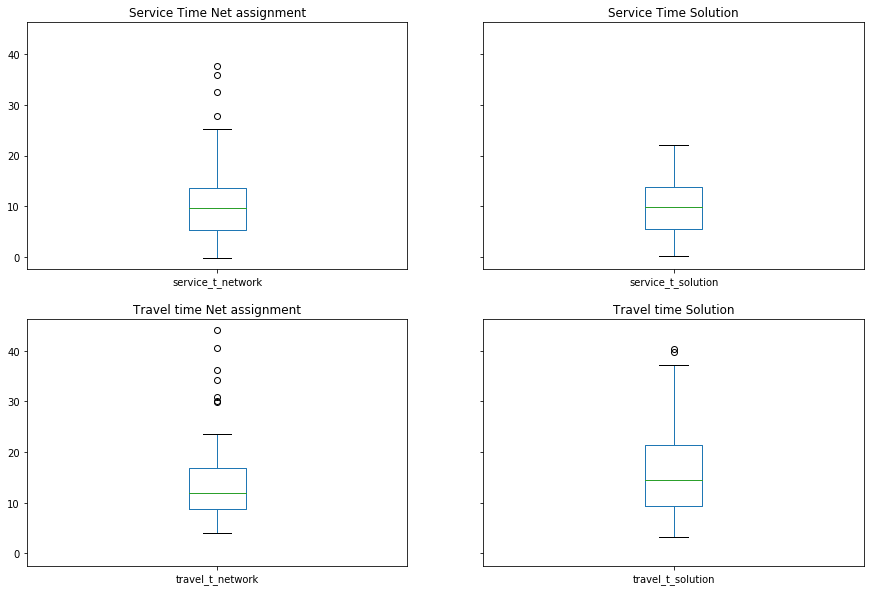

In [8]:
show_statistics_time(total_info1)

In [9]:
print_statistics(total_info1)

Num clients over max. service time: 8
Num clients over max. travel time: 2
--------------------------------- MAX 
Service time network: 37.759	Service time optimal policy 22.032	Difference service time 15.727
Travel  time network: 44.078	Travel  time optimal policy 40.397	Difference travel  time 3.681
Total   time network: 53.499	Total   time optimal policy 52.403	Difference travel   time 1.095
--------------------------------- MEAN 
Service time network: 10.790	Service time optimal policy 9.875	Difference service time 0.916
Travel  time network: 13.798	Travel  time optimal policy 16.022	Difference travel  time -2.224
Total   time network: 24.588	Total   time optimal policy 25.897	Difference travel   time -1.308
--------------------------------- MEDIAN 
Service time network: 9.626	Service time optimal policy 9.901	Difference service time -0.275
Travel  time network: 11.919	Travel  time optimal policy 14.416	Difference travel  time -2.497
Total   time network: 22.485	Total   time optima

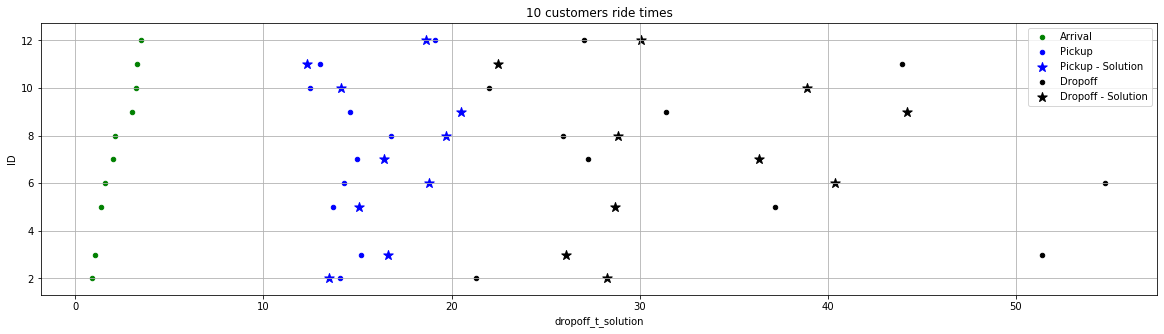

In [10]:
results_comparison(total_info1)

In [11]:
delt1, ride1 = compute_obj(total_info1, Event1)
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delt1, ride1, delt1+ride1))


Delta_t: 2486.067	Ride_t: 14839.137	Objective: 17325.204	
Delta_t: 2360.481	Ride_t: 16841.256	Objective: 19201.737	


## Model 2. Model with 31 channel input with intermediate loss

In [19]:
model2 = torch.load('model_weights2/model_size_30.pt')
model2.eval()
num_channels = 31
im_size = 30

In [20]:
Event2 = generate_event(TABLE, model2, NN, num_channels, im_size)
df_clients_event2, sol_event2 =  generate_times(Event2)
total_info2 = pd.merge(df_clients_event2, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

Visualize results in terms of service time and travel time

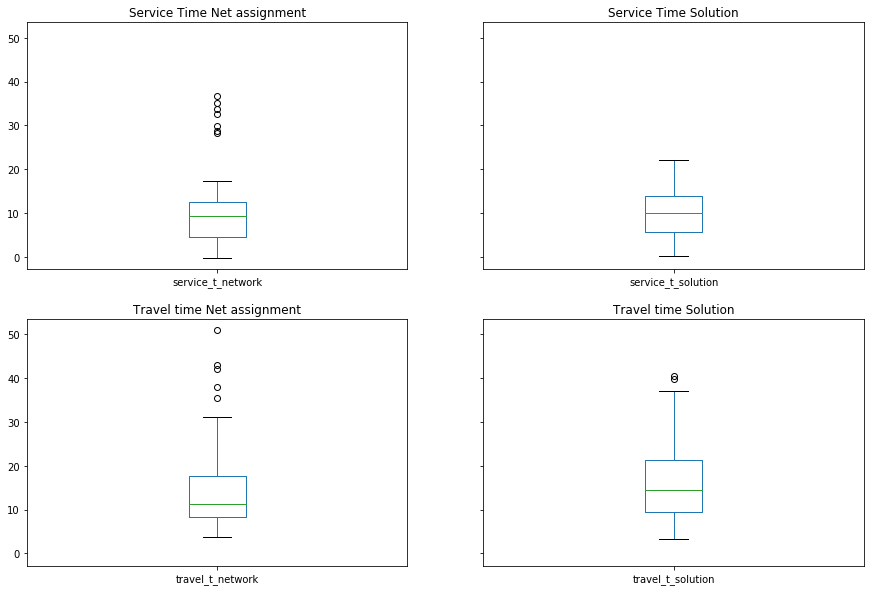

In [21]:
show_statistics_time(total_info2)

In [22]:
print_statistics(total_info2)

Num clients over max. service time: 7
Num clients over max. travel time: 3
--------------------------------- MAX 
Service time network: 36.730	Service time optimal policy 22.032	Difference service time 14.698
Travel  time network: 50.948	Travel  time optimal policy 40.397	Difference travel  time 10.551
Total   time network: 59.034	Total   time optimal policy 52.403	Difference travel   time 6.631
--------------------------------- MEAN 
Service time network: 10.145	Service time optimal policy 9.875	Difference service time 0.270
Travel  time network: 13.759	Travel  time optimal policy 16.022	Difference travel  time -2.263
Total   time network: 23.904	Total   time optimal policy 25.897	Difference travel   time -1.993
--------------------------------- MEDIAN 
Service time network: 9.353	Service time optimal policy 9.901	Difference service time -0.548
Travel  time network: 11.269	Travel  time optimal policy 14.416	Difference travel  time -3.147
Total   time network: 22.480	Total   time optim

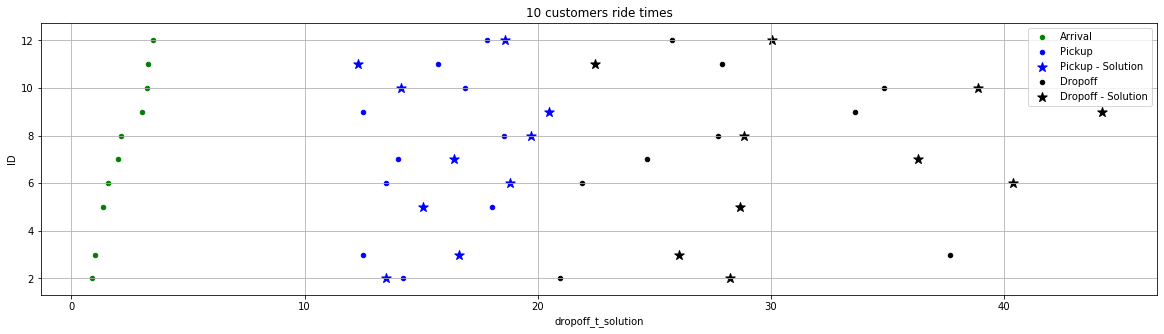

In [23]:
results_comparison(total_info2)

In [24]:
delt2, ride2 = compute_obj(total_info2, Event2)
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delt2, ride2, delt2+ride2))


Delta_t: 2486.067	Ride_t: 14839.137	Objective: 17325.204	
Delta_t: 2294.749	Ride_t: 14969.749	Objective: 17264.498	


## Model 3. Model with 61 channel input (current and future location)

In [18]:
model3 = torch.load('model_weights2/clipped_weights.pt')
model3.eval()
num_channels = 61
im_size = 30

In [19]:
Event3 = generate_event(TABLE, model3, NN, num_channels, im_size)
df_clients_event3, sol_event3 =  generate_times(Event3)
total_info3 = pd.merge(df_clients_event3, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

Visualize results in terms of service time and travel time

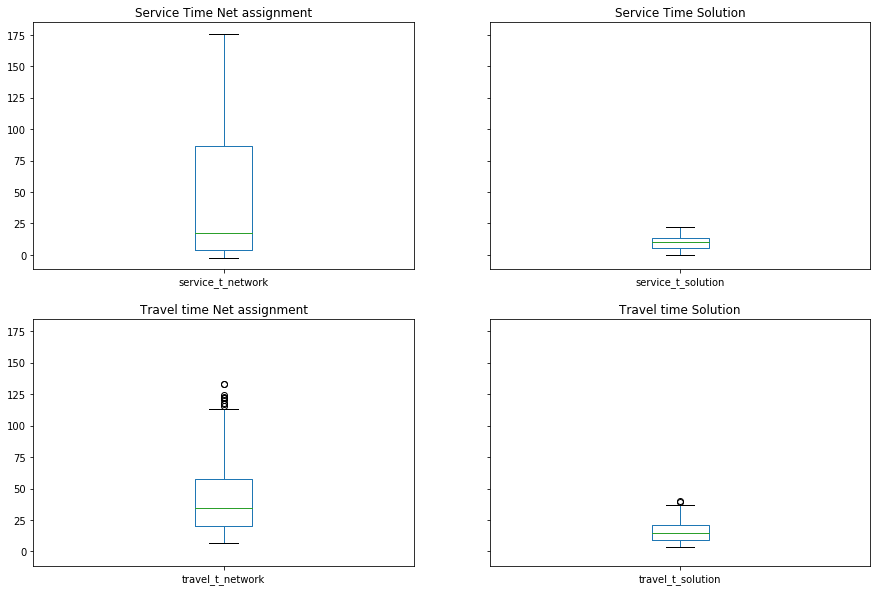

In [20]:
show_statistics_time(total_info3)

In [21]:
print_statistics(total_info3)

Num clients over max. service time: 44
Num clients over max. travel time: 36
--------------------------------- MAX 
Service time network: 175.855	Service time optimal policy 22.032	Difference service time 153.824
Travel  time network: 133.132	Travel  time optimal policy 40.397	Difference travel  time 92.735
Total   time network: 202.290	Total   time optimal policy 52.403	Difference travel   time 149.887
--------------------------------- MEAN 
Service time network: 48.662	Service time optimal policy 9.875	Difference service time 38.787
Travel  time network: 45.510	Travel  time optimal policy 16.022	Difference travel  time 29.489
Total   time network: 94.172	Total   time optimal policy 25.897	Difference travel   time 68.275
--------------------------------- MEDIAN 
Service time network: 17.150	Service time optimal policy 9.901	Difference service time 7.248
Travel  time network: 34.566	Travel  time optimal policy 14.416	Difference travel  time 20.151
Total   time network: 102.712	Total   

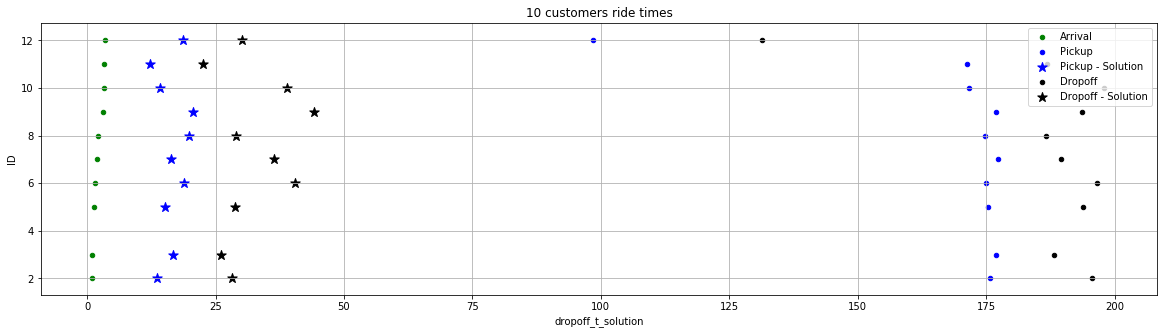

In [22]:
results_comparison(total_info3)

In [38]:
delt3, ride3 = compute_obj(total_info3, Event3)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt3, ride3, delt3+ride3))


Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294	


## Model 4. Model with 2 channel input 

In [24]:
model4 = torch.load('model_weights2/two_channel_weights.pt')
model4.eval()
num_channels = 2
im_size = 30

In [25]:
Event4 = generate_event(TABLE, model4, NN, num_channels, im_size)
df_clients_event4, sol_event4 =  generate_times(Event4)
total_info4 = pd.merge(df_clients_event4, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

Visualize results in terms of service time and travel time

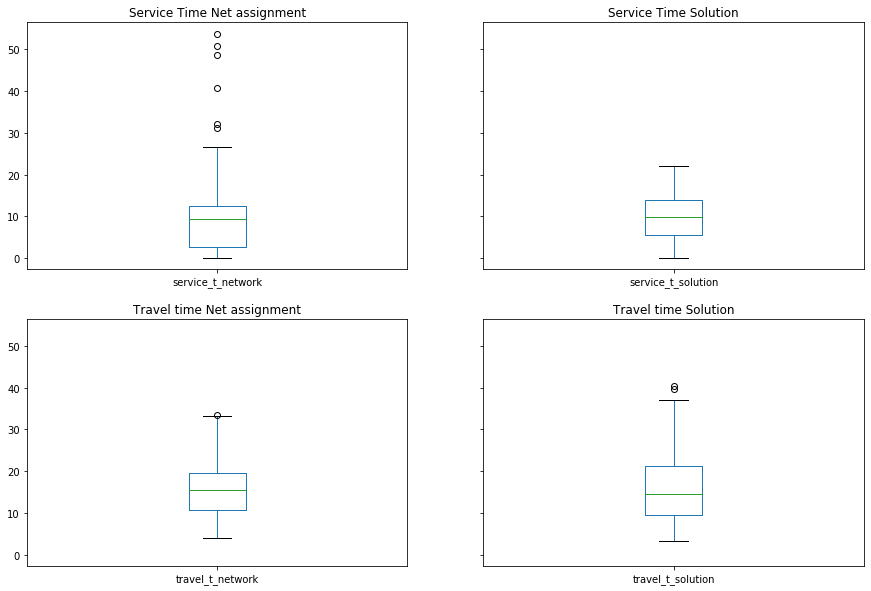

In [26]:
show_statistics_time(total_info4)

In [27]:
print_statistics(total_info4)

Num clients over max. service time: 8
Num clients over max. travel time: 0
--------------------------------- MAX 
Service time network: 53.818	Service time optimal policy 22.032	Difference service time 31.786
Travel  time network: 33.365	Travel  time optimal policy 40.397	Difference travel  time -7.032
Total   time network: 70.628	Total   time optimal policy 52.403	Difference travel   time 18.225
--------------------------------- MEAN 
Service time network: 10.239	Service time optimal policy 9.875	Difference service time 0.364
Travel  time network: 15.998	Travel  time optimal policy 16.022	Difference travel  time -0.024
Total   time network: 26.237	Total   time optimal policy 25.897	Difference travel   time 0.340
--------------------------------- MEDIAN 
Service time network: 9.450	Service time optimal policy 9.901	Difference service time -0.452
Travel  time network: 15.482	Travel  time optimal policy 14.416	Difference travel  time 1.066
Total   time network: 24.929	Total   time optima

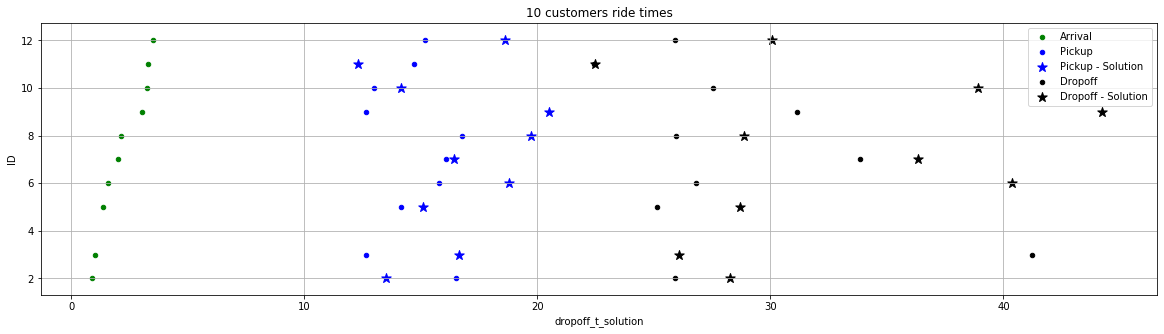

In [28]:
results_comparison(total_info4)

In [29]:
delt4, ride4 = compute_obj(total_info4, Event4)
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delt4, ride4, delt4+ride4))


Delta_t: 2486.067	Ride_t: 14839.137	Objective: 17325.204	
Delta_t: 2518.751	Ride_t: 15909.672	Objective: 18428.423	


## Model 5. Model with im_size=50

In [12]:
model5 = torch.load('model_weights2/model_size_50.pt')
model5.eval()
num_channels = 31
im_size = 50

In [13]:
Event5 = generate_event(TABLE, model5, NN, num_channels, im_size)
df_clients_event5, sol_event5 =  generate_times(Event5)
total_info5 = pd.merge(df_clients_event5, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

Visualize results in terms of service time and travel time

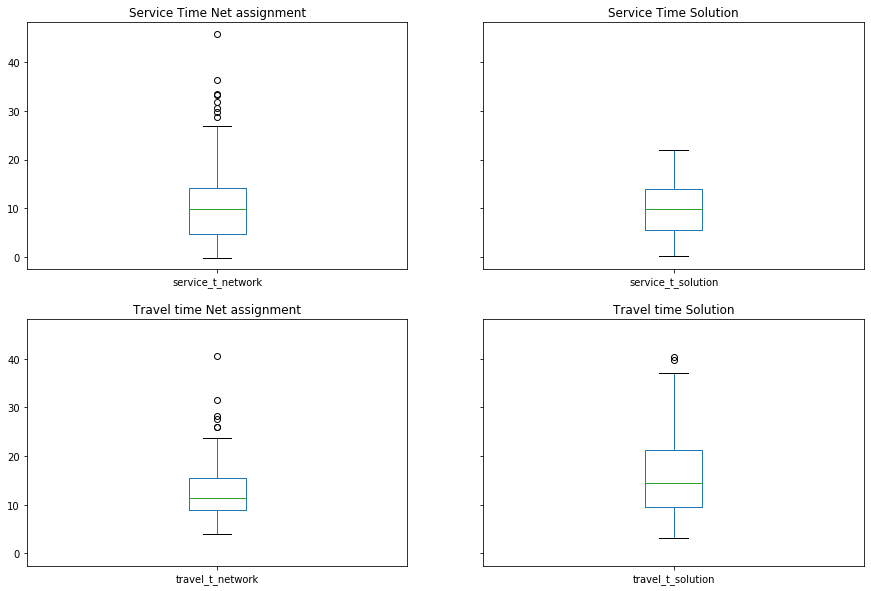

In [14]:
show_statistics_time(total_info5)

In [15]:
print_statistics(total_info5)

Num clients over max. service time: 10
Num clients over max. travel time: 1
--------------------------------- MAX 
Service time network: 45.894	Service time optimal policy 22.032	Difference service time 23.863
Travel  time network: 40.465	Travel  time optimal policy 40.397	Difference travel  time 0.069
Total   time network: 53.455	Total   time optimal policy 52.403	Difference travel   time 1.052
--------------------------------- MEAN 
Service time network: 11.135	Service time optimal policy 9.875	Difference service time 1.260
Travel  time network: 12.717	Travel  time optimal policy 16.022	Difference travel  time -3.305
Total   time network: 23.851	Total   time optimal policy 25.897	Difference travel   time -2.045
--------------------------------- MEDIAN 
Service time network: 9.764	Service time optimal policy 9.901	Difference service time -0.138
Travel  time network: 11.353	Travel  time optimal policy 14.416	Difference travel  time -3.063
Total   time network: 22.654	Total   time optim

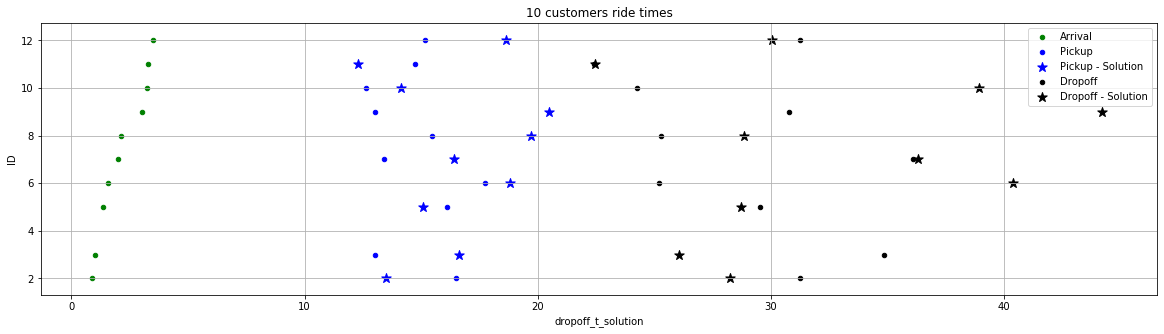

In [16]:
results_comparison(total_info5)

In [17]:
delt5, ride5 = compute_obj(total_info5, Event5)
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delt5, ride5, delt5+ride5))


Delta_t: 2486.067	Ride_t: 14839.137	Objective: 17325.204	
Delta_t: 2289.723	Ride_t: 13990.731	Objective: 16280.453	


## General overview of results

print("model 1. without intermediate loss")
print_statistics(df_clients_event1, sol_event1)
print("model 2. 31 channels")
print_statistics(df_clients_event2, sol_event2)
print("model 3. 61 channels")
print_statistics(df_clients_event3, sol_event3)
print("model 4. 2 channels")
print_statistics(df_clients_event4, sol_event4)

## Random assignment

In [30]:
Event5 = generate_event(TABLE, 0, NN, 0, 0, random=True)
df_clients_event5, sol_event5 =  generate_times(Event5)
total_info5 = pd.merge(df_clients_event5, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

Visualize results in terms of service time and travel time

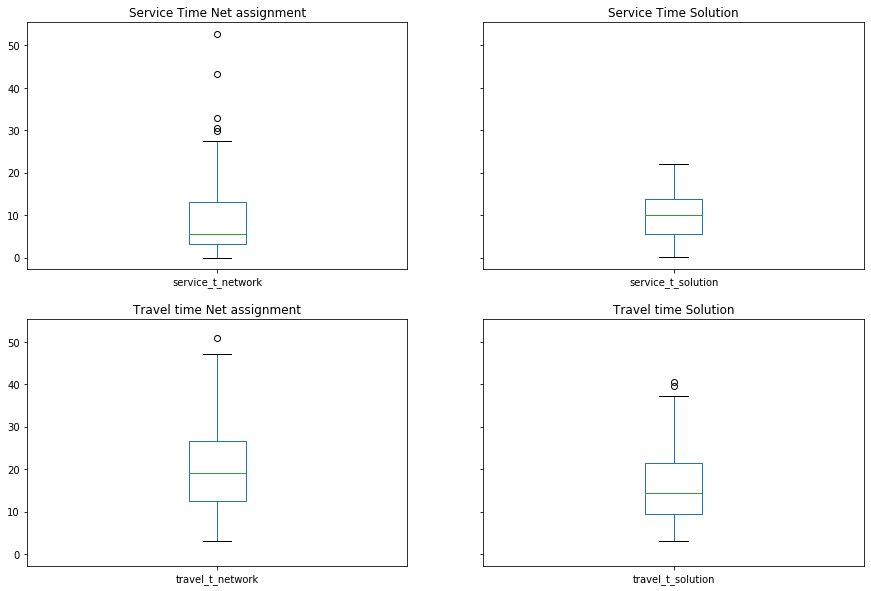

In [31]:
show_statistics_time(total_info5)

In [32]:
print_statistics(total_info5)

Num clients over max. service time: 10
Num clients over max. travel time: 4
--------------------------------- MAX 
Service time network: 52.730	Service time optimal policy 22.032	Difference service time 30.699
Travel  time network: 50.830	Travel  time optimal policy 40.397	Difference travel  time 10.433
Total   time network: 58.556	Total   time optimal policy 52.403	Difference travel   time 6.153
--------------------------------- MEAN 
Service time network: 9.175	Service time optimal policy 9.875	Difference service time -0.699
Travel  time network: 20.505	Travel  time optimal policy 16.022	Difference travel  time 4.483
Total   time network: 29.680	Total   time optimal policy 25.897	Difference travel   time 3.784
--------------------------------- MEDIAN 
Service time network: 5.564	Service time optimal policy 9.901	Difference service time -4.338
Travel  time network: 19.139	Travel  time optimal policy 14.416	Difference travel  time 4.723
Total   time network: 29.667	Total   time optimal

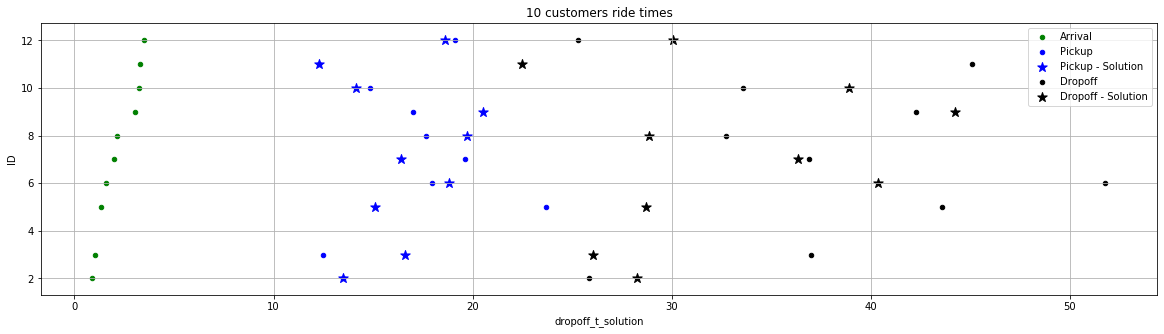

In [33]:
results_comparison(total_info5)

In [34]:
delt5, ride5 = compute_obj(total_info5, Event5)
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f}\tObjective: {:.3f}\t'.format(delt5, ride5, delt5+ride5))


Delta_t: 2486.067	Ride_t: 14839.137	Objective: 17325.204	
Delta_t: 2849.322	Ride_t: 7971.720	Objective: 10821.043	


In [35]:
print('Baseline:\tDelta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Network1:\tDelta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt1, ride1, delt1+ride1))
print('Network2:\tDelta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt2, ride2, delt2+ride2))
print('Network3:\tDelta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt3, ride3, delt3+ride3))
print('Network4:\tDelta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt4, ride4, delt4+ride4))
print('Random: \tDelta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt5, ride5, delt5+ride5))

Baseline:	Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Network1:	Delta_t: 2360.481	Ride_t: 16841.256 	Objective: 19201.737	
Network2:	Delta_t: 2167.552	Ride_t: 16901.368 	Objective: 19068.920	
Network3:	Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294	
Network4:	Delta_t: 2518.751	Ride_t: 15909.672 	Objective: 18428.423	
Random: 	Delta_t: 2849.322	Ride_t: 7971.720 	Objective: 10821.043	


In [42]:
t_base = delta_t_solution + ride_t_solution
t_best = delt2+ride2
(t_best - t_base)/t_base

0.10064619743448557

In [96]:
def results_comparison2(total_info, cust1=0, cust2=10):
    # comparison of results
    simu = total_info[(total_info.ID >= cust1) & (total_info.ID <=cust2)]
    simu['plot_y_network'] = simu['ID']*2
    simu['plot_y_solution'] = simu['ID'].apply(lambda x: x*2 + 1)

    fig, ax = plt.subplots(figsize=(20,5))
    
    #simu.plot(kind='barh', x='pickup_t_network' , end='pickup_t_network',y='ID',  ax=ax)
    
    simu.plot(kind='scatter', x='arrival', y='plot_y_network', ax=ax, c='green')
    simu.plot(kind='scatter', x='arrival', y='plot_y_solution', ax=ax, c='green')
    #simu.plot(kind='scatter', x='pickup_t_solution', y='ID', ax=ax, c='blue', marker='*', s=100)
    #simu.plot(kind='scatter', x='dropoff_t_solution', y='ID', ax=ax, c='black', marker = '*', s=100)
    
    simu[['arrival', 'pickup_t_network', 'travel_t_network', 'plot_y_network']].plot.barh(stacked=True, ax=ax,\
        color=['white', 'white', 'blue'], alpha=0.5, y='plot_y_network')
    simu[['arrival', 'pickup_t_solution', 'travel_t_solution', 'plot_y_solution']].plot.barh(stacked=True, ax=ax,\
        color=['white', 'white', 'green'], alpha=0.5, align='edge', y='plot_y_solution')
    
    #df_clients.iloc[1:10].plot(kind='scatter', x='max_time', y='ID', ax=ax, c='red')
    plt.legend(['Arrival', 'Pickup', 'Pickup - Solution', 'Dropoff', 'Dropoff - Solution'], loc=1)
    plt.grid()
    plt.title('10 customers ride times')
    plt.show()

/Users/nataliebolon/miniconda3/envs/vehicles/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/nataliebolon/miniconda3/envs/vehicles/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


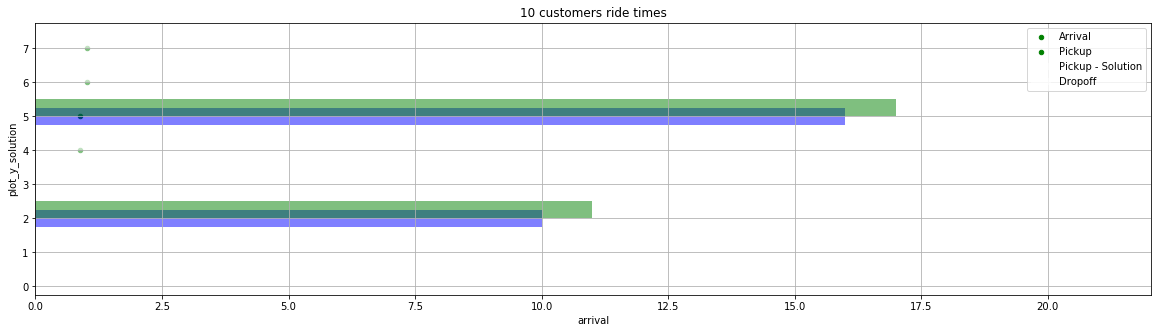

In [97]:
results_comparison2(total_info5)